In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

### Data Description
* ID: Numeric ID, always Filled
* Country: Categories of Demographic information by country can have blanks
* Education: Categories of B1 to B30 can have blanks
* First Contact: Date of First Contact, can have blanks
* Last Contact: Date of Last Contact, can have blanks
* Status: Categories of 1st message, 2nd message, 3rd message or blank
* Stage: Categories of subscribed already, declined/canceled call, did not join the call, interested, not interested, do not contact or blank
* First Call: Date of First Call, can have blanks
* Signed up for a Demo: Date of When they signed up for Demo, can have blanks
* Filled in Customer Survey: Date they filled customer Survey, can have blanks
* Did Sign up to the Platform: Date Signed up to platform, can have blanks
* Account Manager Assigned: Date Account Manager assigned, can have blanks
* Subscribed: Date Subscribed, can have blanks

In [2]:
df = pd.read_csv('SalesCRM - CRM.csv')

In [3]:
date_columns = [
    "First Contact", "Last Contact", "First Call", "Signed up for a demo",
    "Did sign up to the platform", "Filled in customer survey",
    "Account Manager assigned", "Subscribed"
]
for col in date_columns:
    df[col] = (~df[col].isna()).astype(int)

In [4]:
label_encoders = {}
categorical_columns = ['Country', 'Education', 'Status', 'Stage']
for col in categorical_columns:
    le = LabelEncoder()
    df[col].fillna("Unknown", inplace=True)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop('Subscribed', axis=1)
y = df['Subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
feature_importance = clf.feature_importances_
for feature, importance in zip(X.columns, feature_importance):
    print(f"{feature} is approx {importance:.2f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2192
           1       0.88      0.93      0.90        15

    accuracy                           1.00      2207
   macro avg       0.94      0.97      0.95      2207
weighted avg       1.00      1.00      1.00      2207

ID is approx 0.09
Country is approx 0.04
Education is approx 0.01
First Contact is approx 0.00
Last Contact is approx 0.01
Status is approx 0.01
Stage is approx 0.53
First Call is approx 0.01
Signed up for a demo is approx 0.01
Filled in customer survey is approx 0.02
Did sign up to the platform is approx 0.02
Account Manager assigned is approx 0.24


In [19]:
decoded_df = df.copy()  # Create a copy of the dataframe to avoid modifying the original
for col in categorical_columns:
    decoded_df[col] = label_encoders[col].inverse_transform(decoded_df[col])

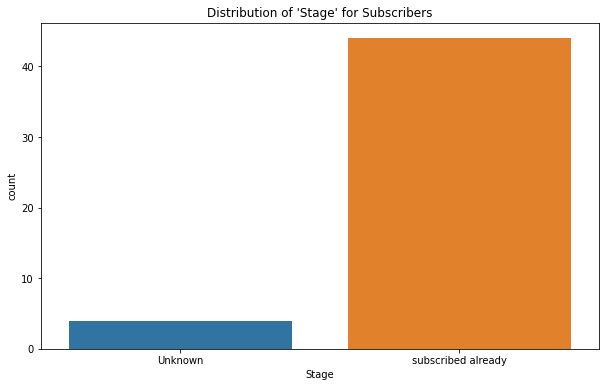

In [20]:
# Inspect distribution of 'Stage' for subscribers
plt.figure(figsize=(10, 6))
sns.countplot(data=decoded_df[decoded_df['Subscribed'] == 1], x='Stage')
plt.title("Distribution of 'Stage' for Subscribers")
plt.show()

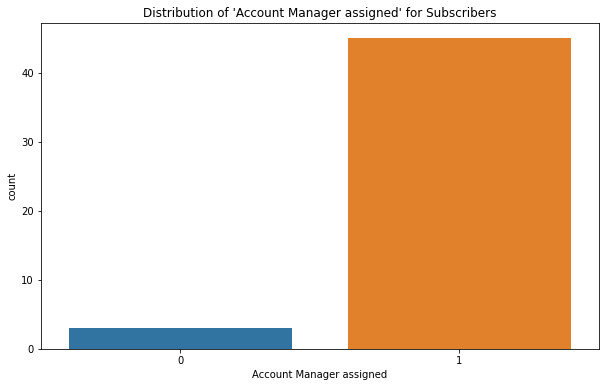

In [17]:
# Inspect distribution of 'Account Manager assigned' for subscribers
plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['Subscribed'] == 1], x='Account Manager assigned')
plt.title("Distribution of 'Account Manager assigned' for Subscribers")
plt.show()

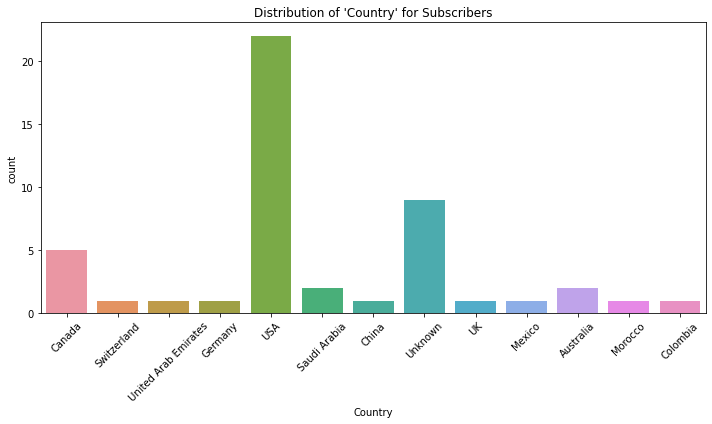

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=decoded_df[decoded_df['Subscribed'] == 1], x='Country')
plt.title("Distribution of 'Country' for Subscribers")
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()  # Adjust layout for better visualization
plt.show()

In [6]:
# Define the Q-network using Scikit-learn's MLPRegressor
q_network = MLPRegressor(hidden_layer_sizes=(128,), activation='relu', solver='adam', max_iter=5000, warm_start=True)
initial_input = np.random.randn(10, X_train.shape[1])
initial_target = np.random.randn(10, 7)
q_network.fit(initial_input, initial_target)

MLPRegressor(hidden_layer_sizes=(128,), max_iter=5000, warm_start=True)

In [7]:
# Define action mapping
action_mapping = {
    0: "make call",
    1: "contact",
    2: "demo",
    3: "survey",
    4: "assign manager",
    5: "subscribe",
    6: "do nothing"
}

def choose_action(state):
    state_values = np.array([list(state.values())])
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(list(action_mapping.keys()))
    q_values = q_network.predict(state_values)
    return np.argmax(q_values)

In [8]:
def get_new_state(state, action):
    new_state = state.copy()
    action_name = action_mapping[action]
    
    if new_state['Stage'] == 2 and (action_name == "make call" or action_name == "contact"):  # do not contact
        return new_state
    
    if action_name == "make call":
        new_state['First Call'] = 1
        if new_state['Stage'] < 3:  # If the stage is less than "interested", move to "interested"
            new_state['Stage'] = 3
    elif action_name == "contact":
        new_state['First Contact'] = 1
    elif action_name == "demo":
        new_state['Signed up for a demo'] = 1
    elif action_name == "survey":
        new_state['Filled in customer survey'] = 1
    elif action_name == "assign manager":
        new_state['Account Manager assigned'] = 1
    
    return new_state

In [9]:
def get_reward(new_state):
    reward = 0
    
    first_contact = new_state['First Contact']
    first_call = new_state['First Call']
    demo = new_state['Signed up for a demo']
    survey = new_state['Filled in customer survey']
    manager = new_state['Account Manager assigned']
    stage = new_state['Stage']
    
    if first_contact:
        reward += 0.1
    if first_call:
        reward += 0.2
    if demo:
        reward += 0.2
    if survey:
        reward += 0.4
    if manager:
        reward += 4.4
    if stage == 3:  # interested
        reward += 2.1
    elif stage == 4:  # not interested
        reward -= 2
    elif stage == 5:  # subscribed already
        reward = 0  # No reward if already subscribed
    elif stage == 2:  # do not contact
        reward -= 5  # Negative reward for contacting a "do not contact" user
    
    return reward

In [10]:
# RL Training Loop
epsilon = 0.2
gamma = 0.95
subscription_threshold = 6.0
total_episodes = 1000

max_steps_per_episode = 500  # Maximum number of steps in each episode

reward_list_limited = []
for episode in range(total_episodes):
    state = df.sample(1).drop('Subscribed', axis=1).iloc[0].to_dict()
    total_reward = 0
    done = False
    step = 0  # Initialize step count for this episode

    while not done and step < max_steps_per_episode:
        action = choose_action(state)
        new_state = get_new_state(state, action)
        reward = get_reward(new_state)
        total_reward += reward
        
        # Update Q-values using the Bellman equation
        target = reward + gamma * np.max(q_network.predict(np.array([list(new_state.values())])))
        with_target = q_network.predict(np.array([list(state.values())]))
        with_target[0][action] = target
        
        # Update the Q-network
        q_network.partial_fit(np.array([list(state.values())]), with_target)
        
        # Check termination condition
        if total_reward >= subscription_threshold:
            done = True
        
        state = new_state
        step += 1  # Increment step count

    reward_list_limited.append(total_reward)

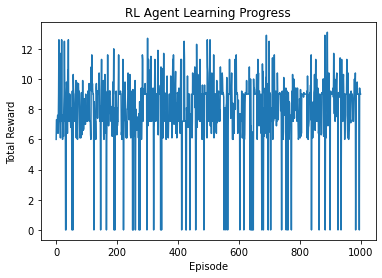

In [11]:
plt.plot(reward_list_limited)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('RL Agent Learning Progress')
plt.show()

In [12]:
# Create a DataFrame to store Q-values and the best action for each state
q_values_df = pd.DataFrame(columns=list(action_mapping.values()) + ['Best Action'])

# Loop through the dataset to compute Q-values for each state
for _, row in df.drop('Subscribed', axis=1).iterrows():
    state_values = np.array([row.values])
    q_values = q_network.predict(state_values)[0]
    best_action = action_mapping[np.argmax(q_values)]
    q_values_df.loc[len(q_values_df)] = list(q_values) + [best_action]

# Display the first few rows of the resulting DataFrame
q_values_df.head()

,make call,contact,demo,survey,assign manager,subscribe,do nothing,Best Action
0,15.029739,2.589784,18.495004,16.633672,74.811220,30.510928,11.576731,assign manager
1,4.228683,-1.711480,4.499886,4.467079,30.080909,8.363757,5.067527,assign manager
2,14.688949,2.556853,18.142269,16.464411,74.218646,30.133841,11.514152,assign manager
3,8.099928,1.373458,8.208235,9.250745,43.141107,15.864729,8.228900,assign manager
4,13.992581,2.407958,17.506548,15.969666,73.085367,29.253837,11.323751,assign manager


## Best Segments

### Insights
* After looking at the Feature importance weights by the random forest model that is predicting with high precision, recall and accuracy we can see that the segments that indicate who is most likely to subscribe are people who have been 
1. Already Subscribed or in the Unknown Stage
     * This is not very actionable in terms of already subscribed, it might help to further contact people in the Unknown stage to clarify their position.
2. Assigned an Account Manager
    * People who have been assigned an account manager are likely to subscribe
3. Are from the U.S
    * While this is not as strong a predictor as the Other two, by far of people who are subscribed most are from the U.S followed by those that are unknown where they are from
    
### Limitations

* There is very little subscriber data to begin with, it causes a pretty big imbalance in the data, this may be affecting the real world accuracy of the model.

* It may be worth removing those that are already subscribed from the data if there is an abundance of subscriber data as it seems to be heavily weighted by the model but it is not actionable/it is difficult to glean useful predictors off of that Since they subscribed prior to company input.

## Best Action

Based on the q values made by the Reinforcment learning model. In general the actions with the most value tend to be:
1. assigning a manager
2. offering a demo
3. Customer taking a survey
4. making a call with them. 